In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

In [2]:
#-----Import the Excel as Dataframe
p2 = pd.read_excel('UHF.xlsx')

In [3]:
ion = 'Cl mg/l'
Start = 935
Time_between_Samples = 14

In [4]:
#-----Getting the 3 bases features
Conduct = p2['Conductivity uS/cm']
Conduct_V2 = Conduct[Start:]
Conduct_V2.interpolate(inplace = True)

Water = p2['water flux mm/hr']
Water.interpolate(inplace = True)

pH = p2['pH']
pH.interpolate(inplace = True)
Samples = len(Conduct_V2)

tx = np.zeros((Samples,8))

#------Log of flux, derivative of flux, yearly sinusoid

log_flux = p2['log_flow']
log_flux.interpolate(inplace=True)
dx_flux = np.gradient(Water)

YEARLY_SAMPLES = 1255
sinusoid = np.zeros(Samples)
for i in range(Samples):
    sinusoid[i]= np.cos(2*i*np.pi/YEARLY_SAMPLES) +1


#------Use a certain number of sample of our ion

y1 = p2[ion]
y = y1[Start:]
y.interpolate(inplace = True)
y = y.to_numpy()

values = np.zeros(Samples)
prev_values = np.zeros(Samples)
temp = y[0]

for i in range(Samples):
    if(i%int(Time_between_Samples*3.5) == 0):
        values[i] = y[i]
    else:
        values[i] = np.nan
        
df = DataFrame(values, columns = ['values'])
df.interpolate(inplace= True)
df = df.to_numpy()
df = df.flatten()

for i in range(Samples):
    if(i != 0):
        prev_values[i] = df[i-1]
               
prev_df = DataFrame(prev_values, columns = ['previous values'])
prev_df = prev_df.to_numpy()
prev_df = prev_df.flatten()

#-----Another way to fill the ion columns: repet n times the value sampled
values2 = []
prev_values2 = []
temp = y[0]
for i in range(Samples):
    if(i%int(Time_between_Samples*3.5) == 0):
        prev = temp
        temp = y[i]
        values2.append(temp)
        prev_values2.append(prev)
    else:
        values2.append(temp)
        prev_values2.append(prev)



#----------construct the feature vector

tx[:,0] = Conduct_V2
tx[:,1] = Water[Start:]
tx[:,2] = pH[Start:]
tx[:,3] = df
tx[:,4] = log_flux[Start:]
tx[:,5] = dx_flux[Start:]
tx[:,6] = sinusoid
tx[:,7] = prev_df


In [5]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    err = y - tx.dot(w)
    grad = -np.dot(tx.T, err) / len(err)
    return grad , err

In [6]:
def calculate_mse(e):
    """Calculate the mse for vector e."""
    return 1/2*np.mean(e**2)

In [7]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

Define the Gradient Descent algorithm

In [8]:
def least_squares_GD(y, tx, initial_w ,max_iters, gamma):
    if(initial_w is None):
        initial_w = np.zeros(tx.shape[1])
    # initialize parameters
    w = initial_w
    loss = 0
    for n_iter in range(max_iters):
        # compute gradient, err, and loss
        grad, err = compute_gradient(y, tx, w)
        loss = calculate_mse(err)
        # update weight
        w = w - gamma * grad
    return w, loss


Implementation of the cross validation

In [9]:
def cross_validation(y, x, k_indices, k, regression_method, **args):
    msk_test = k_indices[k]
    msk_train = np.delete(k_indices, (k), axis=0).ravel()

    x_tr = x[msk_train, :]
    x_te = x[msk_test, :]
    y_tr = y[msk_train]
    y_te= y[msk_test]

    weights, loss = least_squares_GD(y=y_tr, tx=x_tr, **args)


    return weights, loss

In [10]:
#Compute the mean difference between the exacts values and the computeds
def compute_diff(y_prime,y):
    ecart = 0
    for i in range(len(y_prime)):
        ecart += abs(y_prime[i]-y[i])
    mean = ecart /  len(y_prime)
    return mean

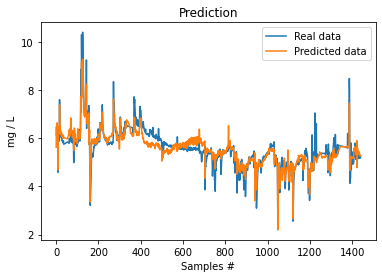

0.2263281801789502


In [13]:
seed = 5
k_fold = 5
k_indices = build_k_indices(y, k_fold, seed)
K_indices = k_indices + Start

gamma = 0.001
max_iters = 10000

accs_train = []
accs_test = []
diff = 0
weights = np.zeros(8)
for k in range(k_fold):
    weight, loss = cross_validation(y, tx, k_indices, k, least_squares_GD, initial_w=None, max_iters=max_iters, gamma=gamma)
    weights += weight

y_prime = tx@(weights/k_fold)
plt.plot(y, label = 'Real data')
plt.plot(y_prime, label = 'Predicted data')
plt.ylabel('mg / L')
plt.xlabel('Samples #')
plt.title('Prediction')
plt.legend()
plt.show()
print(compute_diff(y_prime,y))
    




In [46]:
print(compute_diff(df,y))

0.3296384977672159
